In [2]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

%matplotlib inline

In [3]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [4]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

In [9]:
def ObtainMSE(data, theta0):
    res = ddict(dict)
    for key in data.keys():
        datum = np.squeeze(np.array(data[key]))
        res[key]["Bias"] = np.mean(datum-theta0, axis=1)
        res[key]["Var"] = np.var(datum, axis=1)
        res[key]["MSE"] = np.mean((datum-theta0)**2, axis=1)
    return res

### The work path

In [8]:
root = Path(f"./results/")

## 0. Preprocess the data

In [29]:
n = 60
dirs = root.glob(f"BiostatR1*_n{n}")

dirs = list(dirs)
dirs = sorted(dirs, key=sortdir, reverse=False)

In [30]:
#theta0s = [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#for theta0 in theta0s:
#    idxs = np.array([sortdir(d) for d in dirs])/100
#    idxs = list(np.sort(idxs))
#    
#    dirs = sorted(dirs, key=sortdir, reverse=False)
#    cdir = dirs[idxs.index(theta0)]
#    
#    simData = root/f"./SimBiostatR1_p{sortdir(cdir)}_n{n}.pkl"
#    print(simData)
#    if simData.exists():
#        cleanData = load_pkl(simData)
#    else:
#        cleanData = save_data(cdir)
#        with open(simData, "wb") as f:
#            pickle.dump(cleanData, f)

## 1. To obtaining simple format file for a single setting

In [5]:
def parse_sresult(datum):
    res = {
        "JEF"  : datum["jef"]["theta"],
        "FULL": datum["full"]["theta"],
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "NPP"  : datum["NPP"]["thetah"],
        "LCP"  : datum["LCP"]["thetah"],
        "rMAP" : datum["rMAP"]["thetaP"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "JEF":[],
        "FULL":[],
        "LCP":[],
        "NPP":[],
        "UIPJS":[],
        "UIPD":[],
        "rMAP":[]
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["JEF"].append(simdatum["JEF"])
        retres["FULL"].append(simdatum["FULL"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
        retres["LCP"].append(simdatum["LCP"])
        retres["rMAP"].append(simdatum["rMAP"])
    return retres

### Get the current data

In [31]:
theta0 = 0.2

idxs = np.array([sortdir(d) for d in dirs])/100
idxs = list(np.sort(idxs))
cdir = dirs[idxs.index(theta0)]
simData = root/f"./SimBiostatR1_p{sortdir(cdir)}_n{n}.pkl"

### Obtain the cleaned data

In [32]:
if simData.exists():
    cleanData = load_pkl(simData)
else:
    cleanData = save_data(cdir)
    with open(simData, "wb") as f:
        pickle.dump(cleanData, f)

In [9]:
cleanData = edict(cleanData)

### Obtain the mean and variance and MSE from the posterior sample

In [11]:
res = ObtainMSE(cleanData, theta0)

In [12]:
Biass = ddict()
for key in res.keys():
    Biass[key] = res[key]["Bias"]
BiasDF = pd.DataFrame(Biass)

In [13]:
Vars = ddict()
for key in res.keys():
    Vars[key] = res[key]["Var"]
VarDF = pd.DataFrame(Vars)

In [14]:
MSEs = ddict()
for key in res.keys():
    MSEs[key] = res[key]["MSE"]
MSEDF = pd.DataFrame(MSEs)

###  bias plot

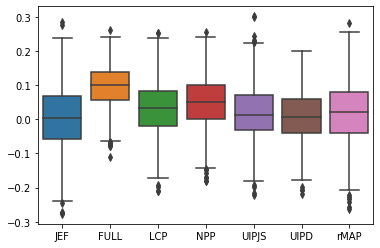

In [15]:
sns.boxplot(data=BiasDF)

In [16]:
BiasDF.mean()

JEF      0.003847
FULL     0.096319
LCP      0.031479
NPP      0.048904
UIPJS    0.017522
UIPD     0.008402
rMAP     0.017893
dtype: float64

### var plot

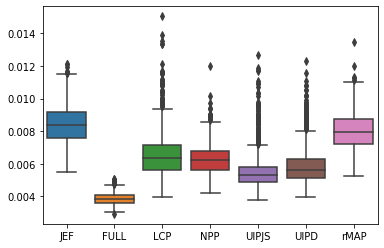

In [17]:
sns.boxplot(data=VarDF)

In [18]:
VarDF.mean()

JEF      0.008456
FULL     0.003873
LCP      0.006572
NPP      0.006283
UIPJS    0.005553
UIPD     0.005900
rMAP     0.008014
dtype: float64

### MSE plot

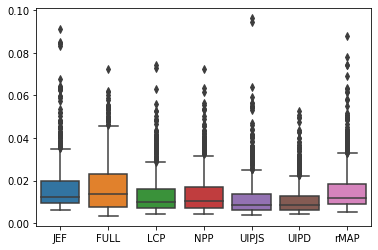

In [19]:
sns.boxplot(data=MSEDF)

#### MSE no full

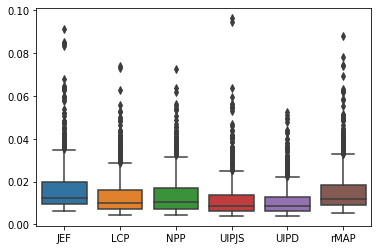

In [20]:
sns.boxplot(data=MSEDF.iloc[:, [0, 2, 3, 4, 5, 6]])

In [21]:
MSEDF.mean()

JEF      0.016697
FULL     0.016814
LCP      0.013173
NPP      0.013768
UIPJS    0.011801
UIPD     0.011032
rMAP     0.015762
dtype: float64

## 2. Plot the bias, variance and MSE for all settings

### n=60

In [19]:
n = 60
fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)

In [21]:
bias60 = ddict(list)
varss60 = ddict(list)
mses60 = ddict(list)
thetas60 = []

In [22]:
for fl in tqdm(fls):
    thetaC = sortdir(fl)/100
    thetas60.append(thetaC)
    cleanData = load_pkl(fl)
    res = ObtainMSE(cleanData, thetaC)
    for key in res.keys():
        bias60[key].append(np.mean(res[key]["Bias"]))
        varss60[key].append(np.mean(res[key]["Var"]))
        mses60[key].append(np.mean(res[key]["MSE"]))

### n=120

In [14]:
n = 120
fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)

In [16]:
bias120 = ddict(list)
varss120 = ddict(list)
mses120 = ddict(list)
thetas120 = []

In [17]:
for fl in tqdm(fls):
    thetaC = sortdir(fl)/100
    thetas120.append(thetaC)
    cleanData = load_pkl(fl)
    res = ObtainMSE(cleanData, thetaC)
    for key in res.keys():
        bias120[key].append(np.mean(res[key]["Bias"]))
        varss120[key].append(np.mean(res[key]["Var"]))
        mses120[key].append(np.mean(res[key]["MSE"]))

results/SimBiostatR1_p0_n120.pkl
results/SimBiostatR1_p10_n120.pkl
results/SimBiostatR1_p20_n120.pkl
results/SimBiostatR1_p30_n120.pkl
results/SimBiostatR1_p40_n120.pkl
results/SimBiostatR1_p50_n120.pkl



In [18]:
linestyles = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.'
    
     ('loosely dotted',        (0, (1, 10))),
     ('densely dotted',        (0, (1, 1))),
    
     ('loosely dashed',        (0, (5, 10))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


In [36]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

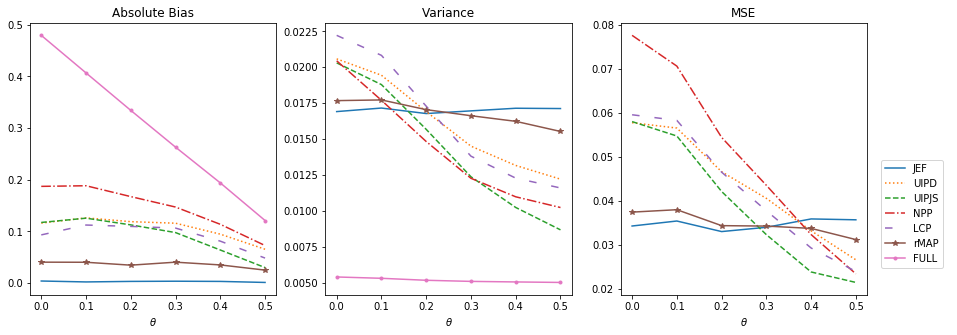

In [47]:
thetas60 = np.array(thetas60)
low = np.argmin(thetas60[thetas60>=0])
up = np.argmax(thetas60[thetas60<=0.5]) + 1

fig = plt.figure(figsize=[15, 5])
axes = fig.subplots(1, 3)

axes[0].set_title("Absolute Bias")
#axes[0].set_ylim([-0.01, 0.5])
axes[0].set_xlabel(r"$\theta$")
axes[0].plot(thetas60[low:up], np.abs(bias60["JEF"][low:up]), label="JEF", linestyle=linestyles[0][1])
axes[0].plot(thetas60[low:up], np.abs(bias60["UIPD"][low:up]), label="UIPD", linestyle=linestyles[1][1])
axes[0].plot(thetas60[low:up], np.abs(bias60["UIPJS"][low:up]), label="UIPJS", linestyle=linestyles[2][1])
axes[0].plot(thetas60[low:up], np.abs(bias60["NPP"][low:up]), label="NPP", linestyle=linestyles[3][1])
axes[0].plot(thetas60[low:up], np.abs(bias60["LCP"][low:up]), label="LCP", linestyle=linestyles[6][1])
axes[0].plot(thetas60[low:up], np.abs(bias60["rMAP"][low:up]), label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[0].plot(thetas60[low:up], np.abs(bias60["FULL"][low:up]), label="FULL", linestyle=linestyles[0][1], marker=".")


axes[1].set_title("Variance")
#axes[2].set_ylim([0.003, 0.01])
axes[1].set_xlabel(r"$\theta$")
axes[1].plot(thetas60[low:up], varss60["JEF"][low:up], label="JEF", linestyle=linestyles[0][1])
axes[1].plot(thetas60[low:up], varss60["UIPD"][low:up], label="UIPD", linestyle=linestyles[1][1])
axes[1].plot(thetas60[low:up], varss60["UIPJS"][low:up], label="UIPJS", linestyle=linestyles[2][1])
axes[1].plot(thetas60[low:up], varss60["NPP"][low:up], label="NPP", linestyle=linestyles[3][1])
axes[1].plot(thetas60[low:up], varss60["LCP"][low:up], label="LCP", linestyle=linestyles[6][1])
axes[1].plot(thetas60[low:up], varss60["rMAP"][low:up], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[1].plot(thetas60[low:up], varss60["FULL"][low:up], label="FULL", linestyle=linestyles[0][1], marker=".")

axes[2].set_title("MSE")
#axes[0].set_ylim([0, 0.05])
axes[2].set_xlabel(r"$\theta$")
axes[2].plot(thetas60[low:up], mses60["JEF"][low:up], label="JEF", linestyle=linestyles[0][1])
axes[2].plot(thetas60[low:up], mses60["UIPD"][low:up], label="UIPD", linestyle=linestyles[1][1])
axes[2].plot(thetas60[low:up], mses60["UIPJS"][low:up], label="UIPJS", linestyle=linestyles[2][1])
axes[2].plot(thetas60[low:up], mses60["NPP"][low:up], label="NPP", linestyle=linestyles[3][1])
axes[2].plot(thetas60[low:up], mses60["LCP"][low:up], label="LCP", linestyle=linestyles[6][1])
axes[2].plot(thetas60[low:up], mses60["rMAP"][low:up], label="rMAP", linestyle=linestyles[0][1], marker="*")
#axes[2].plot(thetas60[low:up], mses60["FULL"][low:up], label="FULL", linestyle=linestyles[0][1], marker=".")
#
#axins = inset_axes(axes[2], width="40%", height="30%", loc='upper right',
#                   bbox_to_anchor=(0.0, -0.6, 1.0, 1.5),
#                   bbox_transform=axes[2].transAxes)
#
#axins.set_xlim([0.2, 0.4])
#axins.set_ylim([0.02, 0.06])
#axins.plot(thetas60[low:up], mses60["JEF"][low:up], label="JEF", linestyle=linestyles[0][1])
#axins.plot(thetas60[low:up], mses60["UIPD"][low:up], label="UIPD", linestyle=linestyles[1][1])
#axins.plot(thetas60[low:up], mses60["UIPJS"][low:up], label="UIPJS", linestyle=linestyles[2][1])
#axins.plot(thetas60[low:up], mses60["NPP"][low:up], label="NPP", linestyle=linestyles[3][1])
#axins.plot(thetas60[low:up], mses60["LCP"][low:up], label="LCP", linestyle=linestyles[6][1])
#axins.plot(thetas60[low:up], mses60["rMAP"][low:up], label="rMAP", linestyle=linestyles[0][1], marker="*")
#axins.plot(thetas60[low:up], mses60["FULL"][low:up], label="FULL", linestyle=linestyles[0][1], marker=".")

handles, labels = axes[0].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc=(0.92, 0.20))

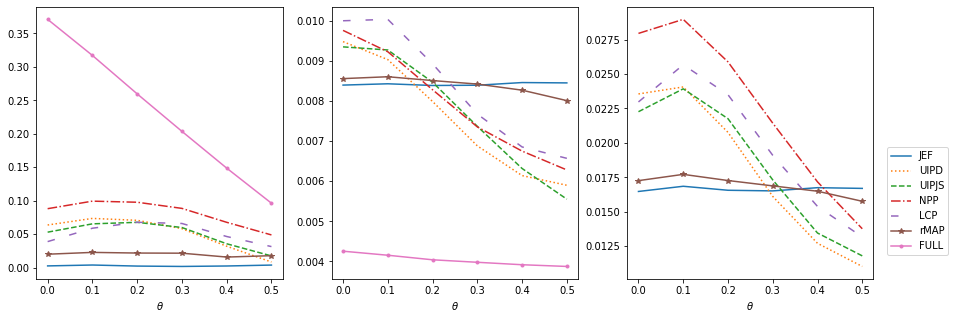

In [46]:
fig = plt.figure(figsize=[15, 5])
axes = fig.subplots(1, 3)

thetas120 = np.array(thetas120)
low = np.argmin(thetas120[thetas120>=0])
up = np.argmax(thetas120[thetas120<=0.5]) + 1

#axes[0].set_title("Absolute Bias")
#axes[0].set_ylim([-0.01, 0.5])
axes[0].set_xlabel(r"$\theta$")
axes[0].plot(thetas120[low:up], np.abs(bias120["JEF"][low:up]), label="JEF", linestyle=linestyles[0][1])
axes[0].plot(thetas120[low:up], np.abs(bias120["UIPD"][low:up]), label="UIPD", linestyle=linestyles[1][1])
axes[0].plot(thetas120[low:up], np.abs(bias120["UIPJS"][low:up]), label="UIPJS", linestyle=linestyles[2][1])
axes[0].plot(thetas120[low:up], np.abs(bias120["NPP"][low:up]), label="NPP", linestyle=linestyles[3][1])
axes[0].plot(thetas120[low:up], np.abs(bias120["LCP"][low:up]), label="LCP", linestyle=linestyles[6][1])
axes[0].plot(thetas120[low:up], np.abs(bias120["rMAP"][low:up]), label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[0].plot(thetas120[low:up], np.abs(bias120["FULL"][low:up]), label="FULL", linestyle=linestyles[0][1], marker=".")


#axes[1].set_title("Variance")
#axes[2].set_ylim([0.003, 0.01])
axes[1].set_xlabel(r"$\theta$")
axes[1].plot(thetas120[low:up], varss120["JEF"][low:up],  label="JEF", linestyle=linestyles[0][1])
axes[1].plot(thetas120[low:up], varss120["UIPD"][low:up], label="UIPD", linestyle=linestyles[1][1])
axes[1].plot(thetas120[low:up], varss120["UIPJS"][low:up],label="UIPJS", linestyle=linestyles[2][1])
axes[1].plot(thetas120[low:up], varss120["NPP"][low:up],  label="NPP", linestyle=linestyles[3][1])
axes[1].plot(thetas120[low:up], varss120["LCP"][low:up],  label="LCP", linestyle=linestyles[6][1])
axes[1].plot(thetas120[low:up], varss120["rMAP"][low:up], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[1].plot(thetas120[low:up], varss120["FULL"][low:up], label="FULL", linestyle=linestyles[0][1], marker=".")

#axes[2].set_title("MSE")
#axes[0].set_ylim([0, 0.05])
axes[2].set_xlabel(r"$\theta$")
axes[2].plot(thetas120[low:up], mses120["JEF"][low:up],   label="JEF",   linestyle=linestyles[0][1])
axes[2].plot(thetas120[low:up], mses120["UIPD"][low:up],  label="UIPD",  linestyle=linestyles[1][1])
axes[2].plot(thetas120[low:up], mses120["UIPJS"][low:up], label="UIPJS", linestyle=linestyles[2][1])
axes[2].plot(thetas120[low:up], mses120["NPP"][low:up],   label="NPP",   linestyle=linestyles[3][1])
axes[2].plot(thetas120[low:up], mses120["LCP"][low:up],   label="LCP",   linestyle=linestyles[6][1])
axes[2].plot(thetas120[low:up], mses120["rMAP"][low:up],  label="rMAP",  linestyle=linestyles[0][1], marker="*")
#axes[2].plot(thetas120[low:up], mses120["FULL"][low:up], label="FULL", linestyle=linestyles[0][1], marker=".")

handles, labels = axes[0].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc=(0.92, 0.20))